In [99]:
import os 
from IPython.display import Audio

from tqdm.notebook import tqdm
os.environ['LIBROSA_CACHE_DIR'] = '/tmp/librosa_cache'
import librosa

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import scipy

In [100]:
audio_files = [
 a.replace("~", "/home/caiwan") for a in [
     "~/test_L.flac", 
     "~/test_R.flac",
     "~/prog/audioarchive/docker/data/A1/211009_0001.wav"
     ]
]

- [Audio Classification with Machine Learning (EuroPython 2019)](https://www.youtube.com/watch?v=uCGROOUO_wY)

In [101]:
def find_closest(a, v):  
    """-> Tuple of index and value"""
    return min(enumerate(a), key=lambda x: abs(x[1]-v))

def find_freq_range(freq_list, fmin, fmax):
    l = find_closest(freq_list, fmin)
    h = find_closest(freq_list, fmax)
    return l[0], h[0]

def gen_freq(NFFT, sample_rate):
    return scipy.fft.fftshift(scipy.fft.fftfreq(NFFT, d=1/sample_rate ))[NFFT//2:NFFT]

def gen_fft(block, NFFT, count = None):
    step = NFFT
    if count > 0:
        step = block.shape[0] // count
    S = []
    for k in range(0, block.shape[0], step):
        x = scipy.fft.fftshift(scipy.fft.fft(block[k:k+NFFT], n=NFFT))[NFFT//2:NFFT]
        x_power = np.real(x*np.conj(x))
        S.append(x_power)

    S = np.array(S)
    max_power= np.square(np.max(S))
    if max_power > 0:
        S = 10*np.log10( S / max_power)

    return S.T

def gen_spectral_data(infile, block_length = 16, frame_length = 4096, hop_length = None, fft_length = 2048, duration=None):
    sample_rate = librosa.get_samplerate(infile)
    for block in librosa.stream(
        infile,
        block_length=block_length, 
        frame_length=frame_length,
        hop_length=hop_length if hop_length else frame_length,
        duration=duration
    ):
        fft = gen_fft(block, fft_length, count=512)
        freq_list = gen_freq(fft_length, sample_rate)
        yield block, fft, freq_list, sample_rate 

infile=audio_files[0]

settings = {
    "block_length": 32, 
    "frame_length": 4096, 
    "hop_length": 4096, 
    "fft_length": 4096, 
    "duration": 12*60
}

spectrum_data = list([s for s in tqdm(gen_spectral_data(infile,**settings ))])

0it [00:00, ?it/s]

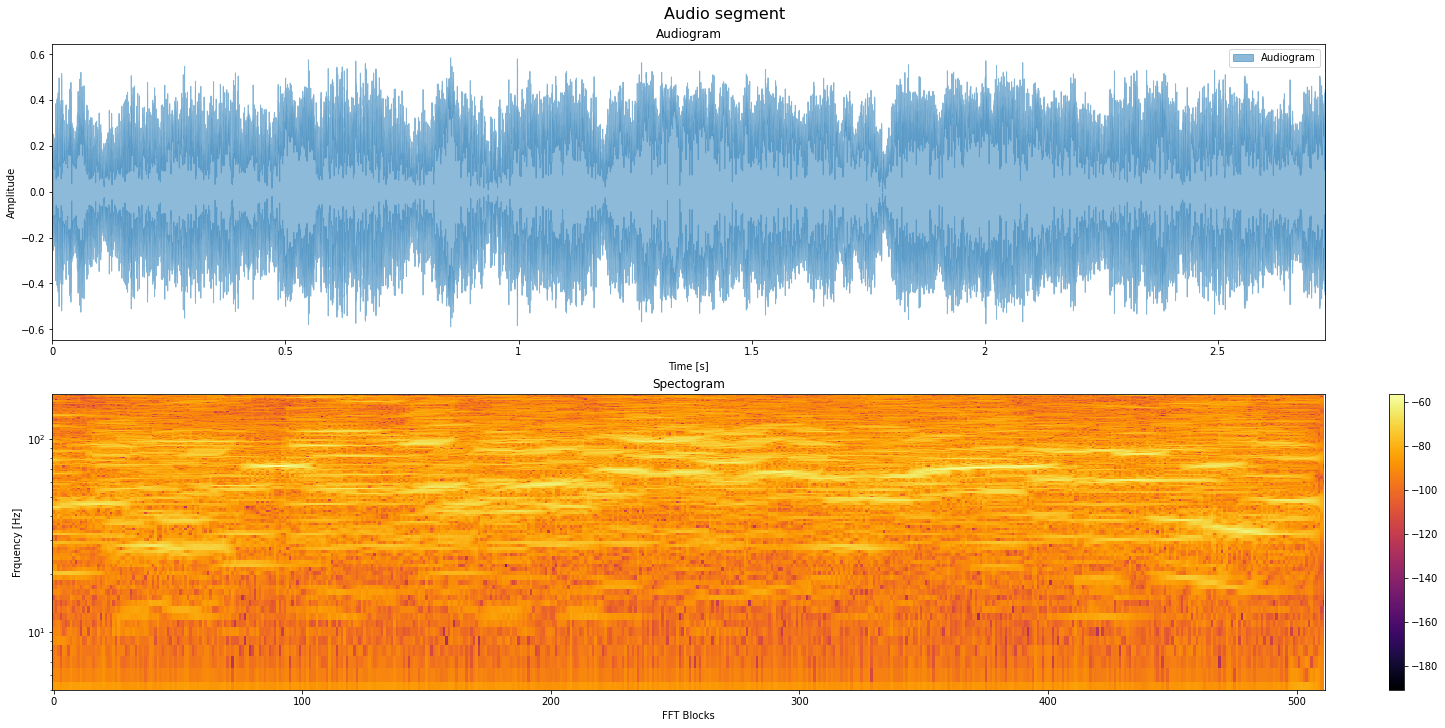

((2048, 512),
 (131072,),
 array([0.00000000e+00, 1.17187500e+01, 2.34375000e+01, ...,
        2.39648438e+04, 2.39765625e+04, 2.39882812e+04]),
 48000)

In [102]:
def plot(audio, spectrum, frequency_list, sample_rate):
    # for index, ((audio, _), sampe_rate, filename) in enumerate(audio_data):
    fig, (audiogram, spectorgram) = plt.subplots(figsize=(20,10), nrows=2, sharex=False, constrained_layout=True)
    fig.suptitle(f"Audio segment", fontsize=16)

    audio_length = audio.size / sample_rate

    librosa.display.waveshow(audio, sr=sample_rate, ax=audiogram, x_axis="time", label="Audiogram", alpha=0.5)
    audiogram.set(title="Audiogram",
        xlabel="Time [s]",
        ylabel="Amplitude",
        xlim=(0,audio_length)
        )
    # audiogram.label_outer()
    audiogram.legend()

    spectrum_img = spectorgram.imshow(spectrum, origin="lower", cmap="inferno", interpolation='nearest', aspect='auto')
    
    spectorgram.set(
        title="Spectogram",
        ylabel="Frquency [Hz]",
        xlabel="FFT Blocks",
        yscale='log',
        ylim=find_freq_range(frequency_list, 60, 2000),
        # xlim=(0,audio_length)
    )
    fig.colorbar(spectrum_img , ax=spectorgram)

    plt.show(fig)

n = 11

plot(*spectrum_data[n])
Audio(spectrum_data[n][0], rate=spectrum_data[n][3])

(spectrum_data[n][1].shape, spectrum_data[n][0].shape, spectrum_data[n][2], spectrum_data[n][3])


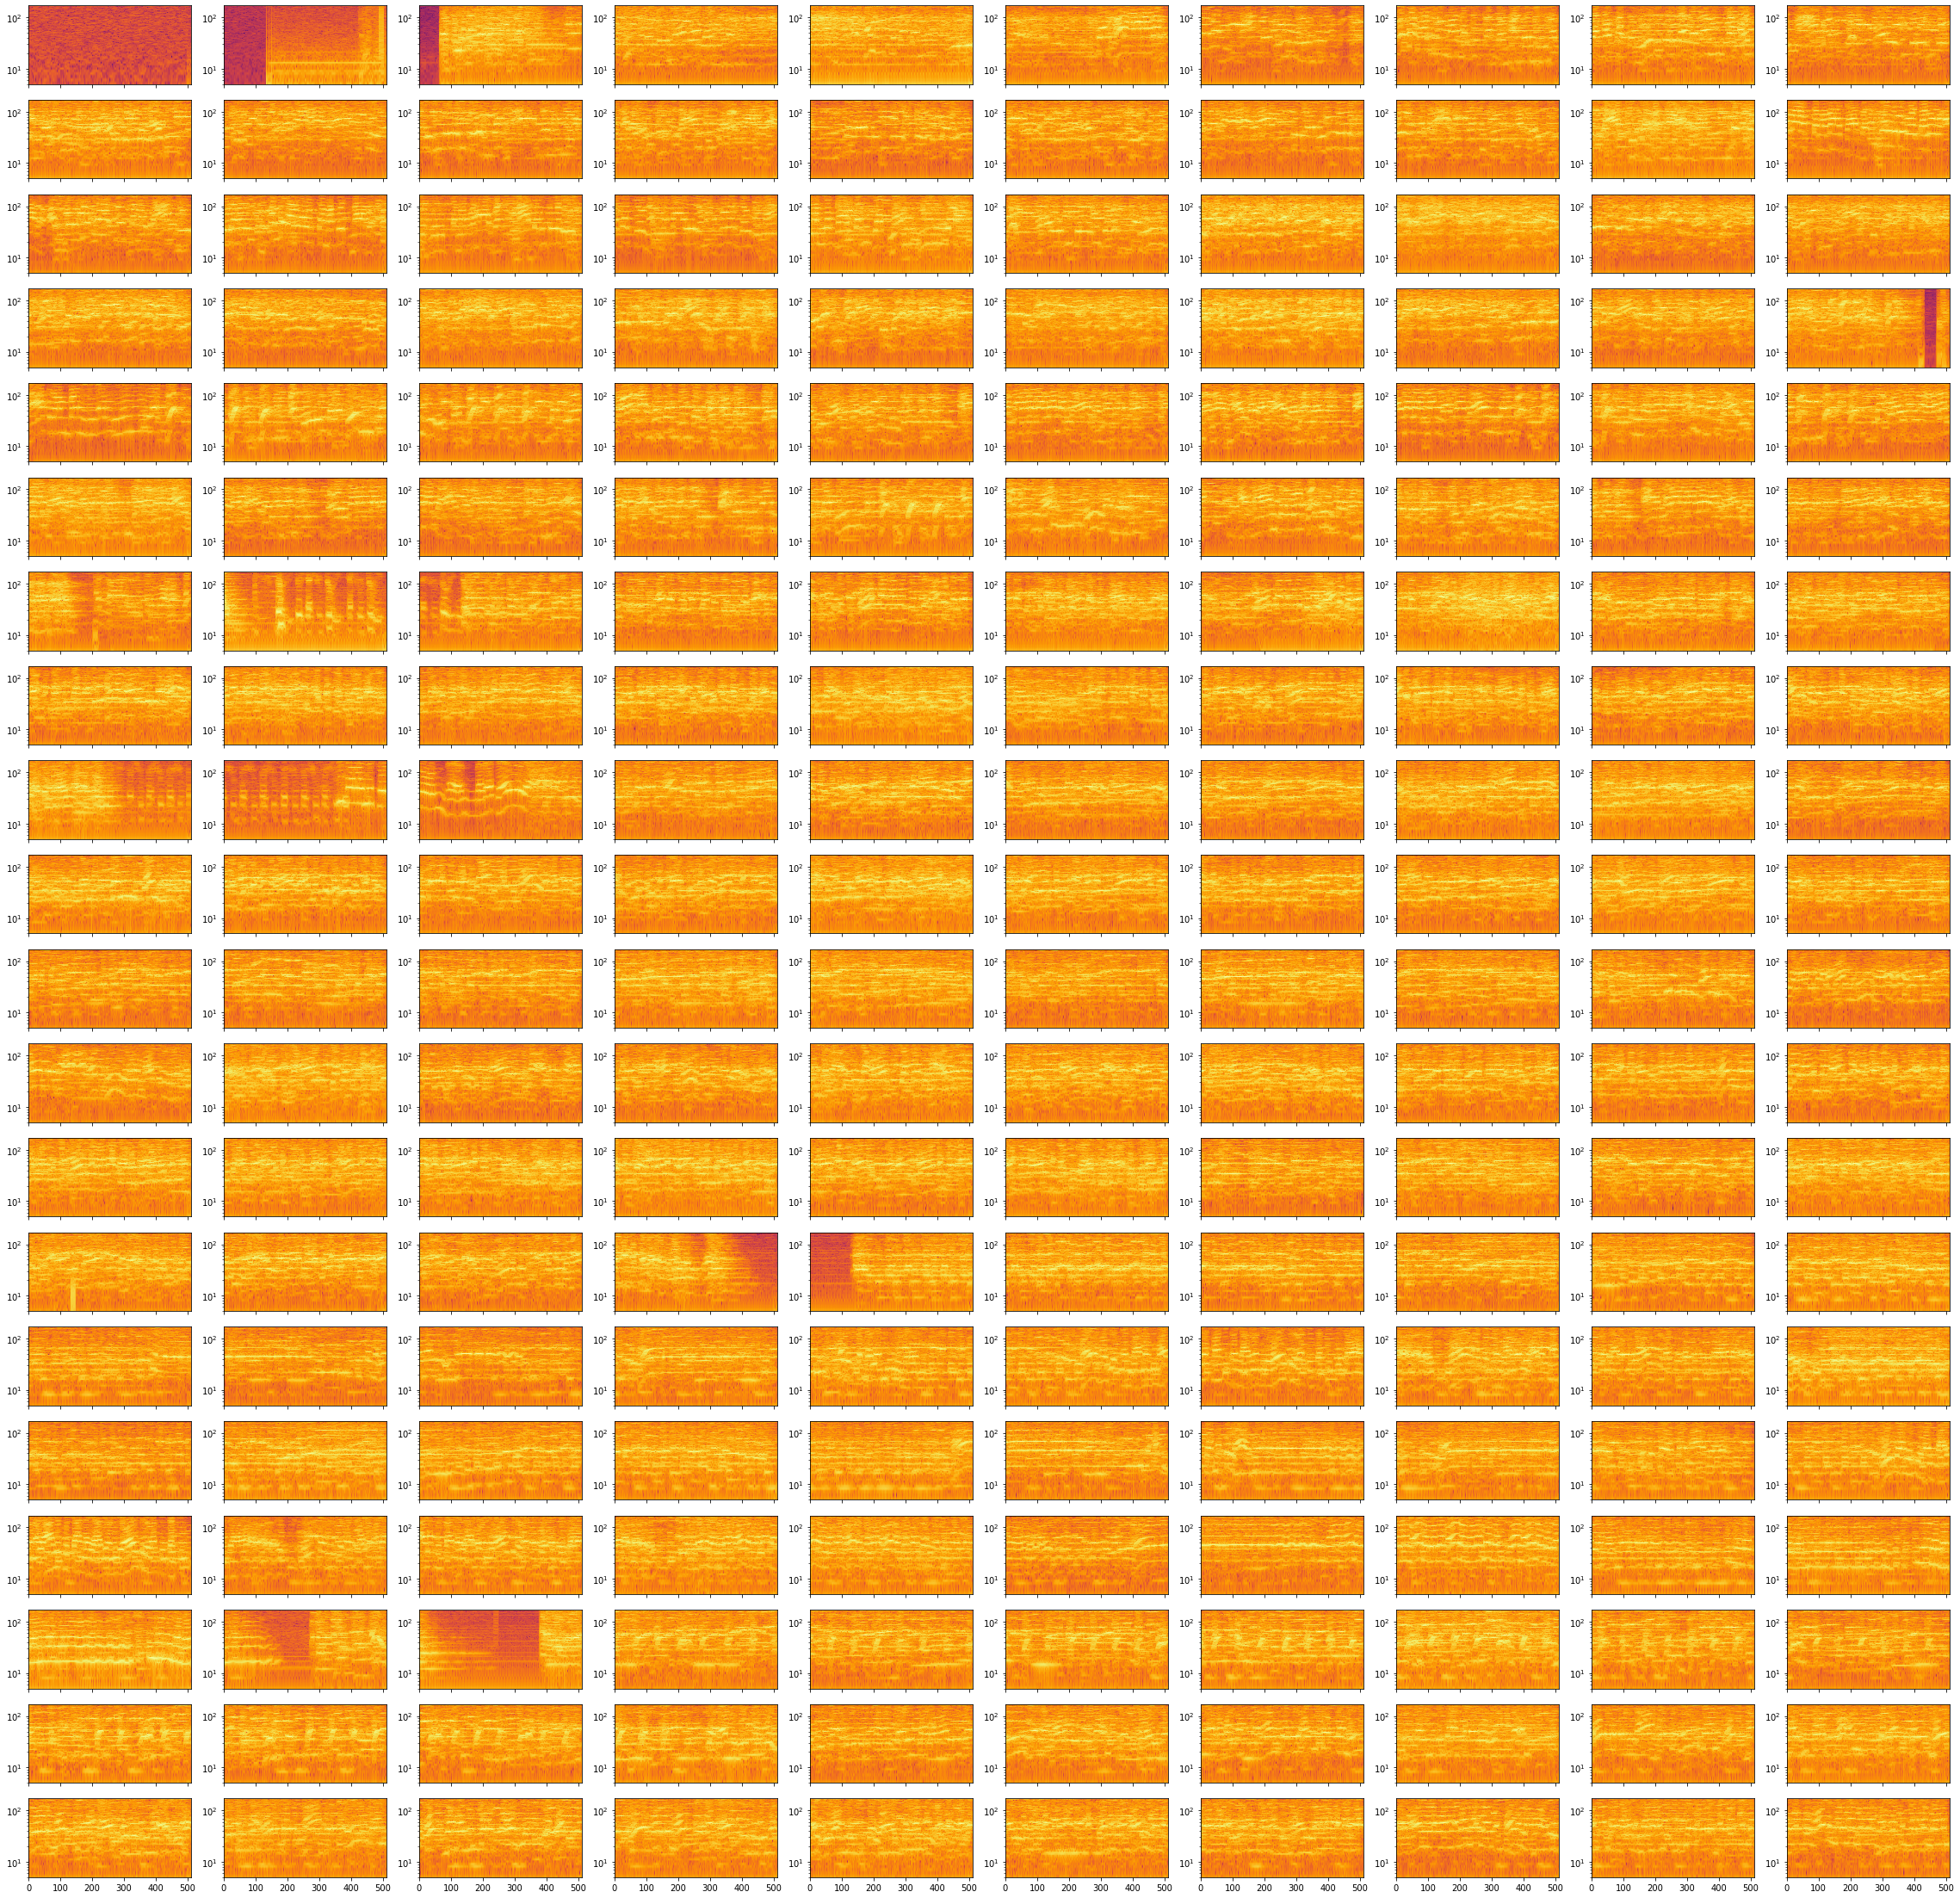

In [103]:
fig, spectorgram_figs = plt.subplots(figsize=(40,40), nrows=20, ncols=10, sharex=True)

def bazdmeg(pina):
    for fasz in pina:
        for geci in fasz:
            yield geci

for index, spectorgram_fig in enumerate(bazdmeg(spectorgram_figs)):
    _, in_data, frequency_list, _2 = spectrum_data[index]
    spectorgram_fig.imshow(in_data, origin="lower", cmap="inferno", aspect="auto")
    spectorgram_fig.set(
        yscale='log',
        ylim=find_freq_range(frequency_list, 60, 2000)
    )

fig.show()

In [104]:
# https://librosa.org/doc/

def save_plot(audio, spectrum, frequency_list, filename, size=64):
    # for index, ((audio, _), sampe_rate, filename) in enumerate(audio_data):
    fig, spectorgram = plt.subplots(figsize=(.1*size, .1*size), dpi=100, sharex=True)
    # fig, spectorgram = plt.subplots()
    
    spectorgram.imshow(spectrum, origin="lower", cmap="inferno", aspect="auto")
    spectorgram.set(yscale='log', ylim=find_freq_range(frequency_list, 200, 2000))
    # spectorgram.set(xlim=(0, audio.size / sample_rate))
    spectorgram.set_axis_off()
    fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
    fig.savefig(filename, bbox_inches='tight', pad_inches=0, dpi=10)
    plt.close()


In [105]:
for index, (audio, spectrum, frequency_list,_b) in tqdm(enumerate(spectrum_data)):
    save_plot(audio, spectrum, frequency_list, f"test/test_{index}.png", size=128)

0it [00:00, ?it/s]